<a href="https://colab.research.google.com/github/Carlonchito95/PracticaCalificada_01/blob/master/focos_nasa_peru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import geopandas as gpd
import fiona
import sqlalchemy
import shapely.speedups
import numpy as np
from unicodedata import normalize
import requests
from pathlib import Path
import urllib
import json
import datetime
import pytz
from sqlalchemy import text
from shapely import wkb
import openpyxl

In [4]:
pip install fiona

In [5]:
url_modis_t_csv='https://firms2.modaps.eosdis.nasa.gov/data/active_fire/modis-c6.1/csv/MODIS_C6_1_South_America_24h.csv'
#url_modis_t_csv = pd.read_csv('imports/modis.csv')
url_viirs_s_csv='https://firms2.modaps.eosdis.nasa.gov/data/active_fire/suomi-npp-viirs-c2/csv/SUOMI_VIIRS_C2_South_America_24h.csv'

#url_viirs_s_csv = pd.read_csv('imports/mentesocial.csv')
url_viirs_n_csv='https://firms2.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/csv/J1_VIIRS_C2_South_America_24h.csv'

url_viirs_n21_csv='https://firms2.modaps.eosdis.nasa.gov/data/active_fire/noaa-21-viirs-c2/csv/J2_VIIRS_C2_South_America_24h.csv'

modis_t = pd.read_csv(url_modis_t_csv)
viirs_s = pd.read_csv(url_viirs_s_csv)
viirs_n = pd.read_csv(url_viirs_n_csv)
viirs_n21 = pd.read_csv(url_viirs_n21_csv)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_viirs_s=viirs_s
#data_viirs_s.head()
data_modis_t=modis_t
#modis_t.head()
data_viirs_n=viirs_n
#data_viirs_n.head()
data_viirs_n21=viirs_n21

In [8]:
data_viirs_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9763 entries, 0 to 9762
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    9763 non-null   float64
 1   longitude   9763 non-null   float64
 2   bright_ti4  9763 non-null   float64
 3   scan        9763 non-null   float64
 4   track       9763 non-null   float64
 5   acq_date    9763 non-null   object 
 6   acq_time    9763 non-null   int64  
 7   satellite   9763 non-null   object 
 8   confidence  9763 non-null   object 
 9   version     9763 non-null   object 
 10  bright_ti5  9763 non-null   float64
 11  frp         9763 non-null   float64
 12  daynight    9763 non-null   object 
dtypes: float64(7), int64(1), object(5)
memory usage: 991.7+ KB


In [9]:
data_viirs_n21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    10642 non-null  float64
 1   longitude   10642 non-null  float64
 2   bright_ti4  10642 non-null  float64
 3   scan        10642 non-null  float64
 4   track       10642 non-null  float64
 5   acq_date    10642 non-null  object 
 6   acq_time    10642 non-null  int64  
 7   satellite   10642 non-null  object 
 8   confidence  10642 non-null  object 
 9   version     10642 non-null  object 
 10  bright_ti5  10642 non-null  float64
 11  frp         10642 non-null  float64
 12  daynight    10642 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 1.1+ MB


In [10]:
data_viirs_n21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    10642 non-null  float64
 1   longitude   10642 non-null  float64
 2   bright_ti4  10642 non-null  float64
 3   scan        10642 non-null  float64
 4   track       10642 non-null  float64
 5   acq_date    10642 non-null  object 
 6   acq_time    10642 non-null  int64  
 7   satellite   10642 non-null  object 
 8   confidence  10642 non-null  object 
 9   version     10642 non-null  object 
 10  bright_ti5  10642 non-null  float64
 11  frp         10642 non-null  float64
 12  daynight    10642 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 1.1+ MB


In [11]:
data_modis_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2192 non-null   float64
 1   longitude   2192 non-null   float64
 2   brightness  2192 non-null   float64
 3   scan        2192 non-null   float64
 4   track       2192 non-null   float64
 5   acq_date    2192 non-null   object 
 6   acq_time    2192 non-null   int64  
 7   satellite   2192 non-null   object 
 8   confidence  2192 non-null   int64  
 9   version     2192 non-null   object 
 10  bright_t31  2192 non-null   float64
 11  frp         2192 non-null   float64
 12  daynight    2192 non-null   object 
dtypes: float64(7), int64(2), object(4)
memory usage: 222.8+ KB


In [12]:
data_modis_t['satellite'] = data_modis_t['satellite'].replace('A', 'MODIS / Aqua')
data_modis_t['satellite'] = data_modis_t['satellite'].replace('T', 'MODIS / Terra')
data_viirs_s['satellite'] = data_viirs_s['satellite'].replace('N', 'VIIRS 375m / S-NPP')
data_viirs_n['satellite'] = data_viirs_n['satellite'].replace('N20', 'VIIRS 375m / NOAA-20')
data_viirs_n21['satellite'] = data_viirs_n21['satellite'].replace('N21', 'VIIRS 375m / NOAA-21')

In [13]:
values_modis=data_modis_t[["latitude","longitude","brightness","scan","track","acq_date","acq_time","satellite","confidence","version","bright_t31","frp", "daynight"]]
values_viirs_s=data_viirs_s[["latitude","longitude","bright_ti4","scan","track","acq_date","acq_time","satellite","confidence","version","bright_ti5","frp", "daynight"]]
values_viirs_n=data_viirs_n[["latitude","longitude","bright_ti4","scan","track","acq_date","acq_time","satellite","confidence","version","bright_ti5","frp", "daynight"]]
values_viirs_n21=data_viirs_n21[["latitude","longitude","bright_ti4","scan","track","acq_date","acq_time","satellite","confidence","version","bright_ti5","frp", "daynight"]]

In [14]:
nasa_compilado= [values_modis,values_viirs_s,values_viirs_n,values_viirs_n21]

In [15]:
nasa_todo= pd.concat(nasa_compilado)

In [16]:
focos_full = gpd.GeoDataFrame(nasa_todo, geometry = gpd.points_from_xy(nasa_todo.longitude, nasa_todo.latitude), crs='EPSG:4326')
focos_full.sindex;

In [17]:
path_file_dos = '/content/drive/MyDrive/Colab Notebooks/imports_colab/limite_municipal_amz_peru.gpkg'
area_amz = gpd.read_file(path_file_dos)

In [18]:
import shapely.speedups
shapely.speedups.enable()

<ipython-input-18-88be23cac5ab>:2: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


In [19]:
focos_amz = gpd.sjoin(focos_full, area_amz, lsuffix = 'focos', rsuffix = 'amz')

In [20]:
focos_amz.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,...,frp,daynight,bright_ti4,bright_ti5,geometry,index_amz,pais,nombre,departamen,cou_int_id
217,-10.96821,-74.90916,303.53,1.41,1.17,2024-10-19,300,MODIS / Terra,56,6.1NRT,...,7.74,N,NaN,NaN,POINT (-74.90916 -10.96821),29,Perú,Chanchamayo,JUNÍN,6
218,-10.10997,-73.88234,311.63,1.72,1.29,2024-10-19,300,MODIS / Terra,83,6.1NRT,...,19.08,N,NaN,NaN,POINT (-73.88234 -10.10997),11,Perú,Atalaya,UCAYALI,6
221,-9.78271,-73.76875,304.43,1.78,1.31,2024-10-19,300,MODIS / Terra,60,6.1NRT,...,8.65,N,NaN,NaN,POINT (-73.76875 -9.78271),11,Perú,Atalaya,UCAYALI,6
222,-9.62882,-75.00933,317.05,1.45,1.19,2024-10-19,300,MODIS / Terra,94,6.1NRT,...,22.83,N,NaN,NaN,POINT (-75.00933 -9.62882),91,Perú,Puerto Inca,HUÁNUCO,6
223,-8.98547,-74.95164,306.85,1.50,1.21,2024-10-19,300,MODIS / Terra,69,6.1NRT,...,9.46,N,NaN,NaN,POINT (-74.95164 -8.98547),91,Perú,Puerto Inca,HUÁNUCO,6


In [21]:
focos_amz=focos_amz.rename(columns={'nombre': 'nome_municipio'})
focos_amz=focos_amz.rename(columns={'departamen': 'nome_DAM'})
focos_amz = focos_amz.drop(['scan','track','confidence','daynight','index_amz','cou_int_id'], axis=1)
focos_amz.head()

,latitude,longitude,brightness,acq_date,acq_time,satellite,version,bright_t31,frp,bright_ti4,bright_ti5,geometry,pais,nome_municipio,nome_DAM
217,-10.96821,-74.90916,303.53,2024-10-19,300,MODIS / Terra,6.1NRT,290.59,7.74,NaN,NaN,POINT (-74.90916 -10.96821),Perú,Chanchamayo,JUNÍN
218,-10.10997,-73.88234,311.63,2024-10-19,300,MODIS / Terra,6.1NRT,293.63,19.08,NaN,NaN,POINT (-73.88234 -10.10997),Perú,Atalaya,UCAYALI
221,-9.78271,-73.76875,304.43,2024-10-19,300,MODIS / Terra,6.1NRT,293.46,8.65,NaN,NaN,POINT (-73.76875 -9.78271),Perú,Atalaya,UCAYALI
222,-9.62882,-75.00933,317.05,2024-10-19,300,MODIS / Terra,6.1NRT,293.85,22.83,NaN,NaN,POINT (-75.00933 -9.62882),Perú,Puerto Inca,HUÁNUCO
223,-8.98547,-74.95164,306.85,2024-10-19,300,MODIS / Terra,6.1NRT,293.84,9.46,NaN,NaN,POINT (-74.95164 -8.98547),Perú,Puerto Inca,HUÁNUCO


In [22]:
focos_amz['acq_time'] = focos_amz['acq_time'].astype(str).str.zfill(4)
focos_amz['Hora'] = focos_amz['acq_time'].str[:2] + ':' + focos_amz['acq_time'].str[2:]
focos_amz.head()

,latitude,longitude,brightness,acq_date,acq_time,satellite,version,bright_t31,frp,bright_ti4,bright_ti5,geometry,pais,nome_municipio,nome_DAM,Hora
217,-10.96821,-74.90916,303.53,2024-10-19,0300,MODIS / Terra,6.1NRT,290.59,7.74,NaN,NaN,POINT (-74.90916 -10.96821),Perú,Chanchamayo,JUNÍN,03:00
218,-10.10997,-73.88234,311.63,2024-10-19,0300,MODIS / Terra,6.1NRT,293.63,19.08,NaN,NaN,POINT (-73.88234 -10.10997),Perú,Atalaya,UCAYALI,03:00
221,-9.78271,-73.76875,304.43,2024-10-19,0300,MODIS / Terra,6.1NRT,293.46,8.65,NaN,NaN,POINT (-73.76875 -9.78271),Perú,Atalaya,UCAYALI,03:00
222,-9.62882,-75.00933,317.05,2024-10-19,0300,MODIS / Terra,6.1NRT,293.85,22.83,NaN,NaN,POINT (-75.00933 -9.62882),Perú,Puerto Inca,HUÁNUCO,03:00
223,-8.98547,-74.95164,306.85,2024-10-19,0300,MODIS / Terra,6.1NRT,293.84,9.46,NaN,NaN,POINT (-74.95164 -8.98547),Perú,Puerto Inca,HUÁNUCO,03:00


In [23]:
focos_amz['hora_nueva'] = focos_amz['acq_date'] + ' ' + focos_amz['Hora']+ ':00-03'

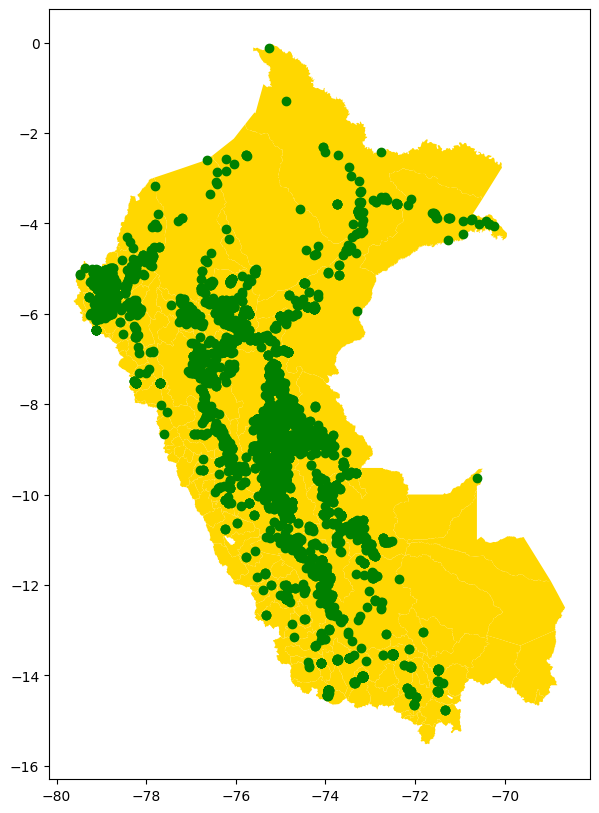

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
area_amz.plot(ax=ax, facecolor='gold')
focos_amz.plot(ax=ax, facecolor='green')
plt.show()

In [25]:
focos_amz.head()

,latitude,longitude,brightness,acq_date,acq_time,satellite,version,bright_t31,frp,bright_ti4,bright_ti5,geometry,pais,nome_municipio,nome_DAM,Hora,hora_nueva
217,-10.96821,-74.90916,303.53,2024-10-19,0300,MODIS / Terra,6.1NRT,290.59,7.74,NaN,NaN,POINT (-74.90916 -10.96821),Perú,Chanchamayo,JUNÍN,03:00,2024-10-19 03:00:00-03
218,-10.10997,-73.88234,311.63,2024-10-19,0300,MODIS / Terra,6.1NRT,293.63,19.08,NaN,NaN,POINT (-73.88234 -10.10997),Perú,Atalaya,UCAYALI,03:00,2024-10-19 03:00:00-03
221,-9.78271,-73.76875,304.43,2024-10-19,0300,MODIS / Terra,6.1NRT,293.46,8.65,NaN,NaN,POINT (-73.76875 -9.78271),Perú,Atalaya,UCAYALI,03:00,2024-10-19 03:00:00-03
222,-9.62882,-75.00933,317.05,2024-10-19,0300,MODIS / Terra,6.1NRT,293.85,22.83,NaN,NaN,POINT (-75.00933 -9.62882),Perú,Puerto Inca,HUÁNUCO,03:00,2024-10-19 03:00:00-03
223,-8.98547,-74.95164,306.85,2024-10-19,0300,MODIS / Terra,6.1NRT,293.84,9.46,NaN,NaN,POINT (-74.95164 -8.98547),Perú,Puerto Inca,HUÁNUCO,03:00,2024-10-19 03:00:00-03


In [26]:
#focos_amz.to_file('./outputs/peru_incendios/FC_NASA_PERU_200924_0800.shp')

ruta_drive = '/content/drive/MyDrive/Colab Notebooks/output_colab/FC_NASA_PERU_201024_0600.shp'
focos_amz.to_file(ruta_drive, index=False)

<ipython-input-26-b08d319d4b8b>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  focos_amz.to_file(ruta_drive, index=False)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'nome_municipio' to 'nome_munic'
  ogr_write(
